**Research Question 1**

What are the most common pickup/drop-off
location pairs, and do these routes correlate with congestion surcharge frequency?

Proposed Methodology: We will analyze the relationships
between all pickup/drop-off location pairs, grouping the
ones most geographically close to each other. This will
involve a clustering algorithm such as k-means or DBSCAN
to capture coordinates that vary slightly, but close enough.
Once the most common location pairs are identified, we will
examine the correlation between them and the congestion
surcharge frequency using statistical analysis techniques.
Correlation coefficients or chi-square tests will be experi-
mented with and the effectiveness of each will be compared.
Finally, we will visualize the results using heatmaps to show
which routes are affected the most by these surcharges.

**Feedback**

For RQ1, I’m not sure if clustering is the best approach to answer it. For example, we don’t want two distant locations (e.g., more than 1 km apart) to be in the same cluster, even if there are many data points in between. However, you can try it and see how it works. I suggest using a map to present the data points and cluster centers (or displaying each cluster’s data in a distinct color) for a specific city.

**Plan**

1. take cleaned data and get all location ids for pickup/dropoff pairs

2. get gps location/coordinates for them using taxi data dictionary

3. use PCA to reduce from 4D (pu_lat, pu_long, do_lat, do_long) to 3D

4. use HDBSCAN to cluster the coordinates

5. Calculate Cramer's V between the cluster labels and congestion surcharge

6. visualize the results using a heatmap


# Data preprocessing

In [ ]:
!pip install pandas pyarrow

In [1]:
import pandas as pd

# concatenate all files into single dataframe
alldata = (pd.read_parquet(f"cleaned_data/1.parquet")).head(1500000)
for i in range(2, 13):
  alldata = pd.concat([alldata, (pd.read_parquet(f"cleaned_data/{i}.parquet")).head(1500000)])

In [ ]:
# get pickup and dropoff IDs
gps_data = pd.DataFrame()
gps_data["PUID"] = alldata["PULocationID"]
gps_data["DOID"] = alldata["DOLocationID"]
gps_data["congestion_surcharge"] = alldata["congestion_surcharge"]

# drop outside of nyc zones
gps_data = gps_data[gps_data["PUID"] != 265]
gps_data = gps_data[gps_data["DOID"] != 265]
gps_data

In [ ]:
# use lookup to get location names
lookup = pd.read_csv("taxi_zone_lookup.csv")
lookup = list(lookup["Zone"].iloc(0))
lookup = lookup[:len(lookup)-2]

# remove slashes from names and add city, state for geocoder
lookup = [name.replace('/', ' ') + ", New York, NY" for name in lookup]
lookup

In [ ]:
!pip install matplotlib geopy utm

In [4]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time

# get longitude/latitude of each PU_zone, DO_zone pair
geolocator = Nominatim(user_agent="gps", timeout=20)

def get_coords(location_name):
    try:
        location = geolocator.geocode(location_name, exactly_one=True)
        return (location.latitude, location.longitude) if location else (None, None)

    except GeocoderTimedOut:
        print("Timed out...Retrying..")
        time.sleep(5)
        return get_coords(location_name)

In [ ]:
coords = []

for name in lookup:
    coord = get_coords(name)
    
    coords.append(coord)
    
    time.sleep(1) 

coords

In [ ]:
gps_data[['PU_lat', 'PU_long']] = gps_data["PUID"].apply(lambda x: pd.Series(coords[x-2]))
gps_data[['DO_lat', 'DO_long']] = gps_data["DOID"].apply(lambda x: pd.Series(coords[x-2]))

# Drop rows where either 'lat' or 'long' is NaN
gps_data = gps_data.dropna(subset=['PU_lat', 'PU_long', 'DO_lat', 'DO_long'])

gps_data

In [ ]:
import utm
import numpy as np
from sklearn.preprocessing import StandardScaler

X = gps_data[["PU_lat","PU_long", "DO_lat", "DO_long"]].values

# Turn latitude/longitude to cartesian (UTM) coordinates
def latlong_to_utm(row):
    pu_utm = utm.from_latlon(row[0], row[1], force_zone_number=18)
    do_utm = utm.from_latlon(row[2], row[3], force_zone_number=18)
    return [pu_utm[0], pu_utm[1], do_utm[0], do_utm[1]]

X_utm = [latlong_to_utm(row) for row in X]
X_utm = np.array(X_utm, dtype=float)
X_utm

In [ ]:
# scale the data to normalize the range of values
scaler = StandardScaler()
scaled = scaler.fit_transform(X_utm)
scaled

In [36]:
# remove outliers
z_threshold = 1

# Find rows where all features are within thresholds
valid_rows = np.all(
    (np.abs(scaled) < z_threshold),   
    axis=1
)

# Filter the data
scaled = scaled[valid_rows]
gps_data = gps_data[valid_rows]
gps_data[["PU_lat","PU_long", "DO_lat", "DO_long"]] = scaled

# congestion surcharge is either 2.5 or 0 so turn it into 0 or 1
gps_data["congestion_surcharge"] = gps_data["congestion_surcharge"].map(lambda x: 1 if x > 0.0 else 0)

gps_data.to_parquet('gps_data.parquet', index=False)
gps_data

,PUID,DOID,congestion_surcharge,PU_lat,PU_long,DO_lat,DO_long
0,161,141,1,0.222520,-0.382782,0.112241,-0.278261
4,107,79,1,0.040525,-0.456357,0.218441,-0.136762
5,161,137,1,0.222520,-0.382782,0.199143,-0.088608
9,141,107,1,0.087470,-0.294663,0.067419,-0.433901
11,79,264,1,0.198702,-0.147659,0.992352,-0.188297
...,...,...,...,...,...,...,...
1499986,90,166,1,0.087654,-0.527739,0.105578,-0.540737
1499987,170,90,1,-0.858765,0.951219,0.112417,-0.502611
1499988,246,232,1,0.065762,-0.643435,0.041484,-0.364392
1499992,141,224,1,0.087470,-0.294663,0.199984,-0.262932


# PCA reduction + HDBSCAN Clustering

In [ ]:
import pandas as pd
import numpy as np

gps_data = pd.read_parquet('gps_data.parquet')
X = gps_data[["PU_lat", "PU_long",	"DO_lat", "DO_long"]].to_numpy()
X

In [ ]:
# check explainable variability by pca components
pca = PCA()
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
cumulative_explained_variance

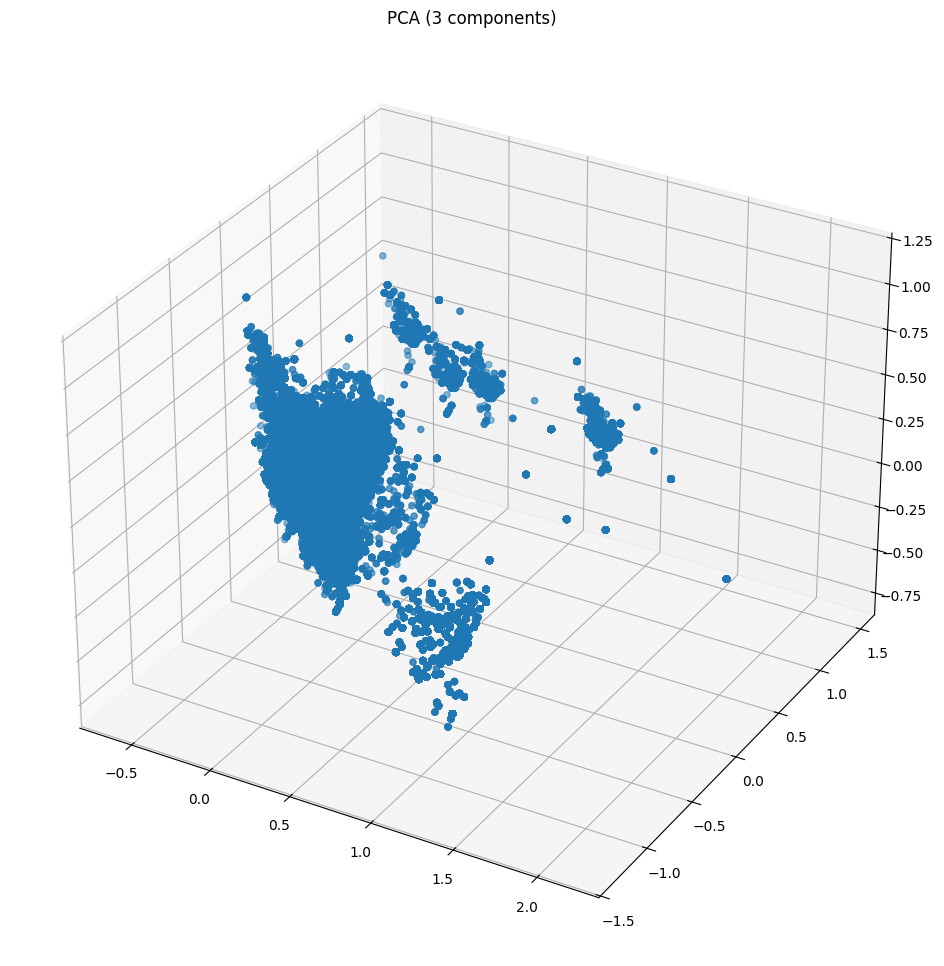

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA (3D)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
np_Xpca = np.asarray(X_pca)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(np_Xpca[:, 0], np_Xpca[:, 1], np_Xpca[:, 2])
plt.title("PCA (3 components)")
plt.show()

In [3]:
import hdbscan

# HDBSCAN to create clusters
cluster = hdbscan.hdbscan_.HDBSCAN(
    min_cluster_size=10_000, 
    min_samples=250,
    cluster_selection_method='eom', 
    algorithm='boruvka_kdtree',
    prediction_data=True,  
    approx_min_span_tree=True  
)

# lower memory usage
np_Xpca = np_Xpca.astype(np.float32)

# Train with 500,000 sample
sample_idx = np.random.choice(len(np_Xpca), 500_000, replace=False)
sample = np_Xpca[sample_idx]
cluster.fit(sample)  

# Predict labels for full dataset, label -1 means no cluster or outlier
labels, _ = hdbscan.approximate_predict(cluster, np_Xpca)

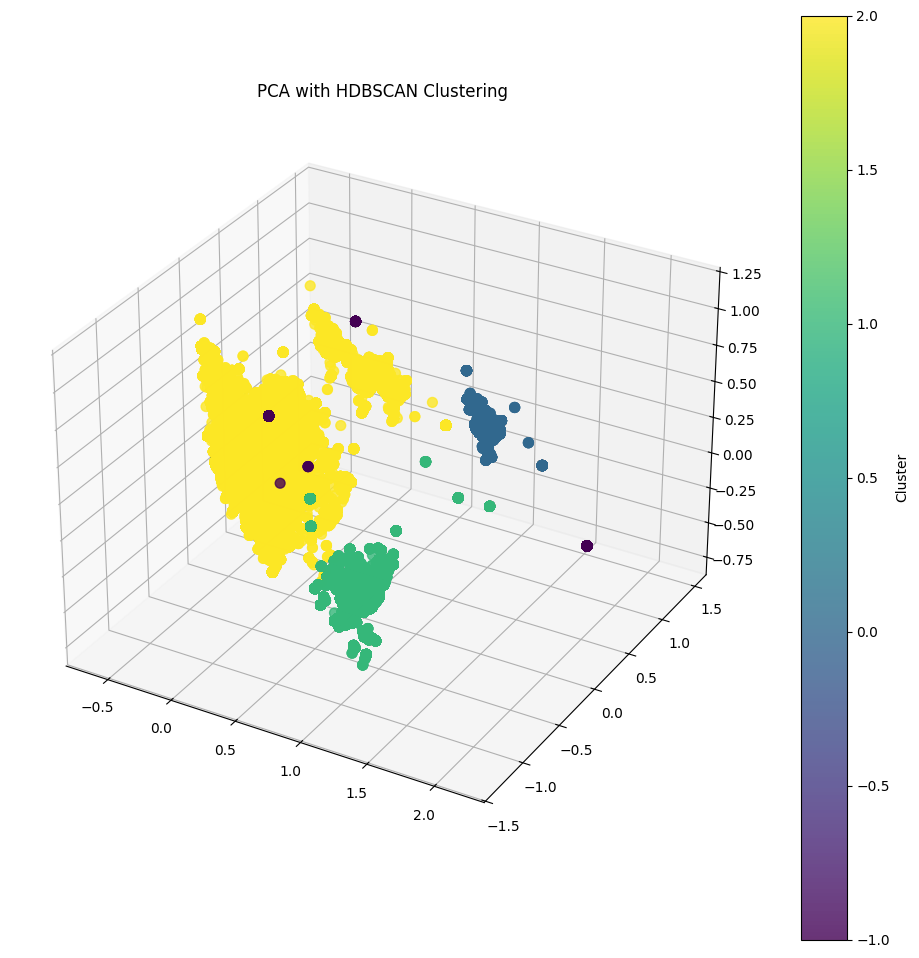

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    np_Xpca[:, 0], np_Xpca[:, 1], np_Xpca[:, 2],
    c=labels,           
    cmap='viridis',        
    s=50,                 
    alpha=0.8               
)
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title("PCA with HDBSCAN Clustering")
plt.show()

In [5]:
import pandas as pd

# add labels column to gps_data
labels_df = pd.DataFrame(labels, columns=["labels"])
gps_data["labels"] = labels
gps_data.to_parquet('gps_data.parquet', index=False)
gps_data

,PUID,DOID,congestion_surcharge,PU_lat,PU_long,DO_lat,DO_long,labels
0,161,141,1,0.222520,-0.382782,0.112241,-0.278261,2
1,107,79,1,0.040525,-0.456357,0.218441,-0.136762,2
2,161,137,1,0.222520,-0.382782,0.199143,-0.088608,2
3,141,107,1,0.087470,-0.294663,0.067419,-0.433901,2
4,79,264,1,0.198702,-0.147659,0.992352,-0.188297,2
...,...,...,...,...,...,...,...,...
6242887,90,166,1,0.087654,-0.527739,0.105578,-0.540737,2
6242888,170,90,1,-0.858765,0.951219,0.112417,-0.502611,1
6242889,246,232,1,0.065762,-0.643435,0.041484,-0.364392,2
6242890,141,224,1,0.087470,-0.294663,0.199984,-0.262932,2


# Cramer's V

In [ ]:
!pip install association_metrics

<Axes: >

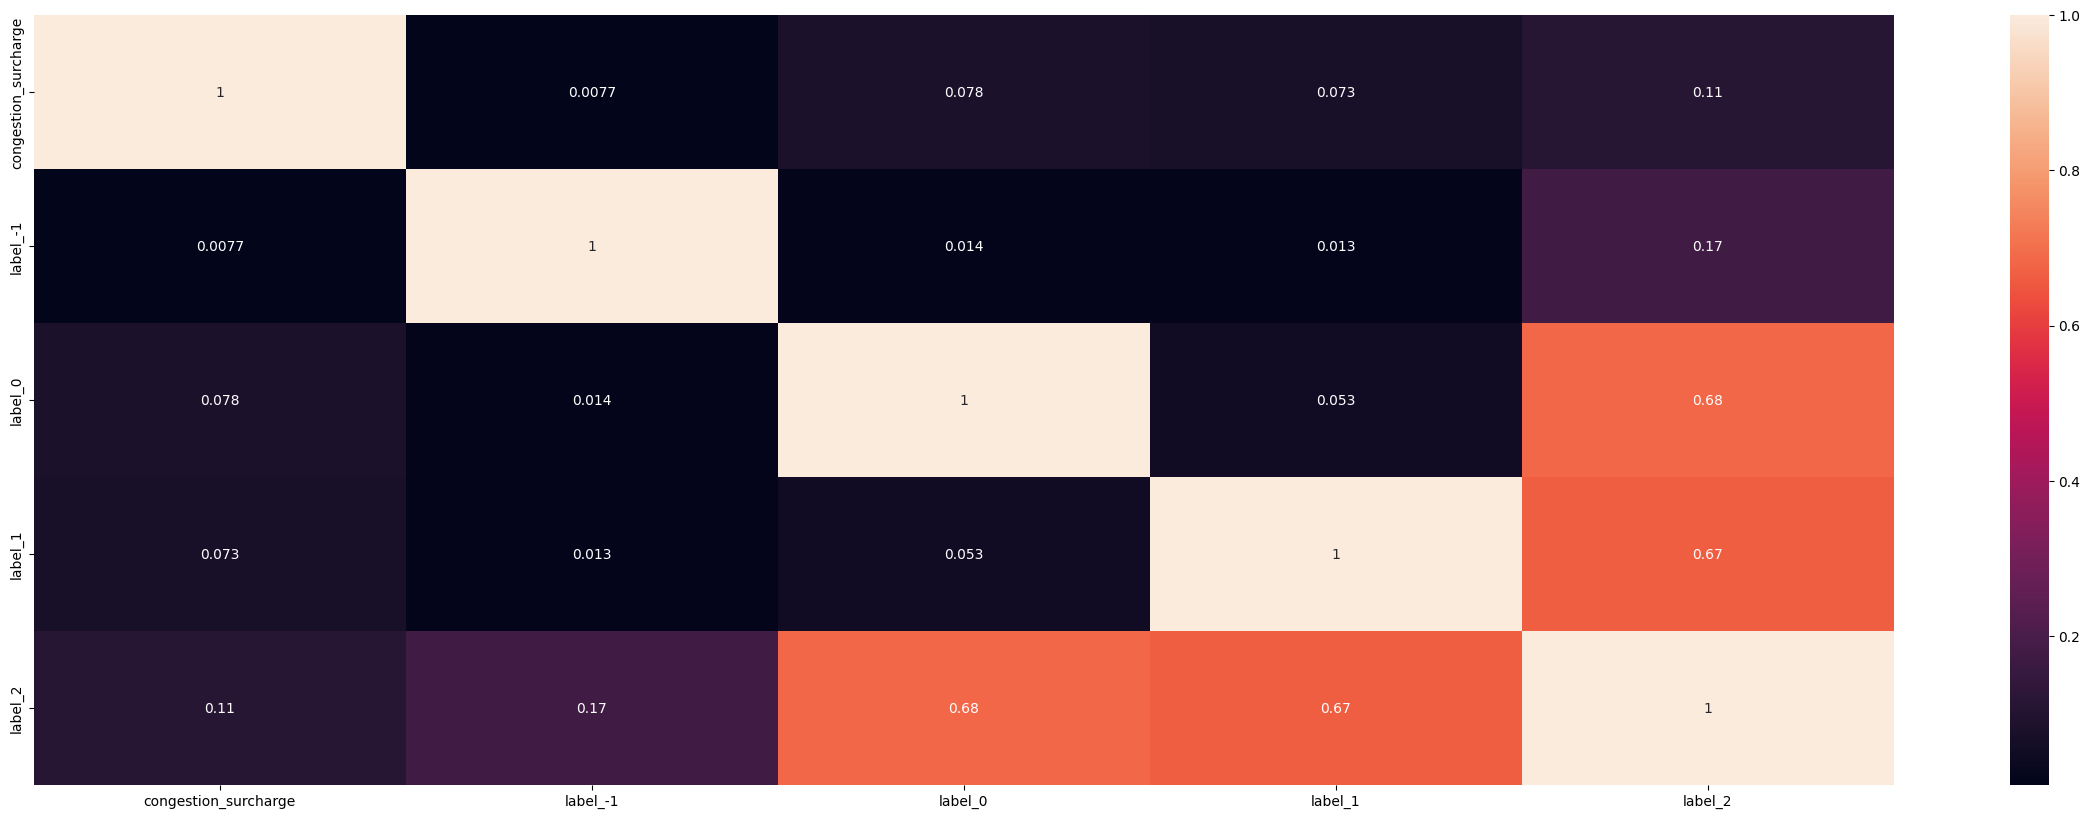

In [6]:
import pandas as pd
import association_metrics as am
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

gps_data = pd.read_parquet('gps_data.parquet')

# one shot encode labels
labels_encode = pd.get_dummies(gps_data["labels"], prefix='label', dtype='int')
labels_encode["congestion_surcharge"] = gps_data["congestion_surcharge"]

# turn columns into category type
labels_encode = labels_encode.astype('category')

cramersv = am.CramersV(labels_encode[['congestion_surcharge', 'label_-1', 'label_0', 'label_1', 'label_2']])

fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(cramersv.fit(), ax=ax, annot=True)

The cluster of trips with the strongest association was label 2 (largest cluster) with a Cramer's V of 0.11, meaning trips belonging to this cluster are most affected by the congestion surcharge fee. 

However, a Cramer's V of 0.11 is still relatively low so cluster labelling alone is not the most important factor in determining the congestion surcharge.

Trips belonging to label 0 and label 1 are less associated than label 2 with Cramer's V of 0.078 and 0.073 respectively.

Trips belonging to label -1 (outliers) have negligible association, which makes sense since they are unusual routes meaning they are less likely to be affected by the congestion surcharge.